In [1]:
from datasets import load_dataset

ds = load_dataset("uoft-cs/cifar10", download_mode='reuse_cache_if_exists')

c:\Users\X\Anaconda3\envs\llama_factory\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 166395.73 examples/s]


In [2]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})


In [5]:
X_train = ds['train']['img']
Y_train = ds['train']['label']
X_test = ds['test']['img']
Y_test = ds['test']['label']

In [6]:
type(Y_test)

list

In [13]:
print(X_train.shape)

torch.Size([50000, 3, 32, 32])


In [8]:
# shape (B, C, W, H) -> (B, H, W, C)
X_train = torch.from_numpy(np.array(X_train)).transpose(1, 3).float().to(device)
Y_train = torch.tensor(Y_train).to(device)
X_test = torch.from_numpy(np.array(X_test)).transpose(1, 3).float().to(device)
Y_test = torch.tensor(Y_test).to(device)

In [9]:
class CNN(nn.Module):
    
    def __init__(self, num_classes=10):
        super().__init__()
        # in shape 3*32*32
        self.l1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=1), # 32*29*29
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #32*14*14
            nn.BatchNorm2d(32)
        )
        # in shape 32*14*14
        self.l2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=1), #32*11*11
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #32*5*5
            nn.BatchNorm2d(32),
            nn.Flatten()
        )
        # in shape 32*5*5
        self.l3 = nn.Sequential(
            nn.Linear(in_features=32*5*5, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        return x
model = CNN().to(device)


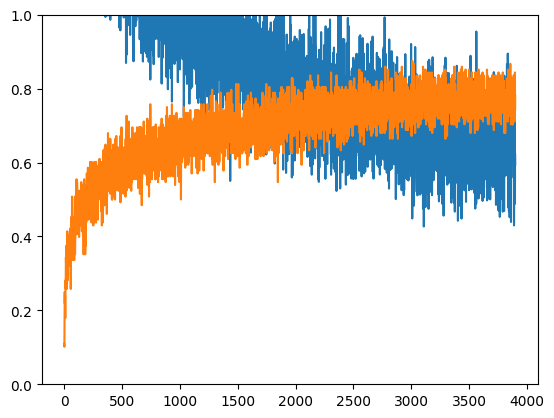

In [10]:
B = 128
epoch = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
losses, accs = [], []
for e in range(epoch):
    for i in range(X_train.shape[0] // B):
        samp = np.random.randint(0, X_train.shape[0], size=B)
        X = X_train[samp]
        Y = Y_train[samp]
        optimizer.zero_grad()
        out = model(X)
        acc = (torch.argmax(out, dim=1) == Y).float().mean().cpu()
        accs.append(acc)
        loss = loss_fn(out, Y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
plt.ylim(0, 1)
plt.plot(losses)
plt.plot(accs)

In [11]:
with torch.no_grad():
    Y_pred = model(X_test)
    acc = (torch.argmax(Y_pred, dim=1) == Y_test).float().mean()
    print(acc)

tensor(0.6705, device='cuda:0')
